In [1]:
# Standard library imports:
import csv
from collections import defaultdict

# Need to be installed (but are defaults for Anaconda):
import numpy as np
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def convert_to_int(answer):
    """
    Convert to integer by removing the text part of the answer (using split),
    and then casting the leading numbers to an int.
    """
    return int(answer.split()[0])


def get_ratings(responses, questions):
    """
    Get ratings for all participants as a dictionary with key=Response ID, value=responses.
    """
    ratings = defaultdict(list)
    for response in responses:
        identifier = response['ResponseId']
        ratings[identifier] = [convert_to_int(response[question]) for question in questions]
    return ratings


def internal_correlations(ratings):
    """
    Compute correlations between users and all other users.
    """
    correlations = dict()
    users = set(ratings.keys())
    for user, scores in ratings.items():
        other_users  = users - {user}
        other_scores = np.array([ratings[key] for key in other_users])
        reference    = np.average(other_scores, axis=0)
        correlation, significance = spearmanr(scores, reference)
        correlations[user] = correlation
    return correlations

In [3]:
# Open the file:
with open("./Responses/RME/RME_May 2, 2022_12.18.csv") as f:
    reader = csv.DictReader(f)
    entries = list(reader)

# Get relevant questions:
relevance = [key for key in entries[0].keys() if key.endswith("_R")]
coherence = [key for key in entries[0].keys() if key.endswith("_C")]

# Get all rows with responses:
responses = entries[2:]

# Get the ratings for all participants:
coherence_ratings = get_ratings(responses, coherence)
relevance_ratings = get_ratings(responses, relevance)

In [4]:
# Build index with correlations between user ratings and the average of all other users.
# Do this for coherence and relevance separately:
coherence_index = internal_correlations(coherence_ratings)
relevance_index = internal_correlations(relevance_ratings)

# Combine the two indices into one list of dictionaries.
# Each dictionary corresponds to a respondent:
combined = [dict(user=ident, 
                 coherence=coherence_index[ident],
                 relevance=relevance_index[ident]) for ident in coherence_index]

# Convert to Pandas dataframe:
df = pd.DataFrame(combined)

/Users/emiel/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [5]:
# Show the table:
df = df.dropna()
df

,user,coherence,relevance
0,R_3EcF6IVWcPglesP,0.610096,0.241139
1,R_22RfNdkCPLbe8ze,0.542990,0.359291
2,R_1ig54MgpjbWYxth,0.593722,0.395695
3,R_22ukLnQElAzxzgh,0.500549,0.226717
4,R_24vkcii8Xj1oGZt,-0.145468,0.006774
5,R_1escUy6gozjeqFy,0.614671,0.331624
6,R_2WA93YtjPl3tmMO,0.530220,0.343901
7,R_1PZXoZzRDYYj1Df,0.604636,0.417763
8,R_2ronumgGEtAN3jX,0.193655,0.195965
9,R_27KgFqPhLCLTA3F,0.348701,0.186441


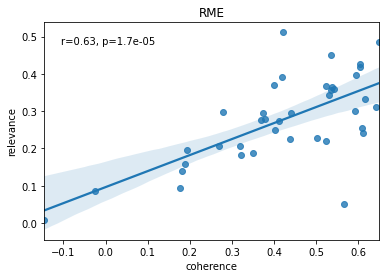

In [6]:
# Plot the responses.
# Each point represents a respondent.
# Both axes correspond to the respondents' correlation with other respondents' responses.
# The top right corner shows respondents who show very similar rating behavior for both types of responses.
# The bottom left corner shows respondents that are very dissimilar.
ax = sns.regplot(data=df, x="coherence", y="relevance")

r, p = spearmanr(df['coherence'], df['relevance'])

ax.set(title="RME")
ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

plt.savefig("Figures/RME-participants.pdf")